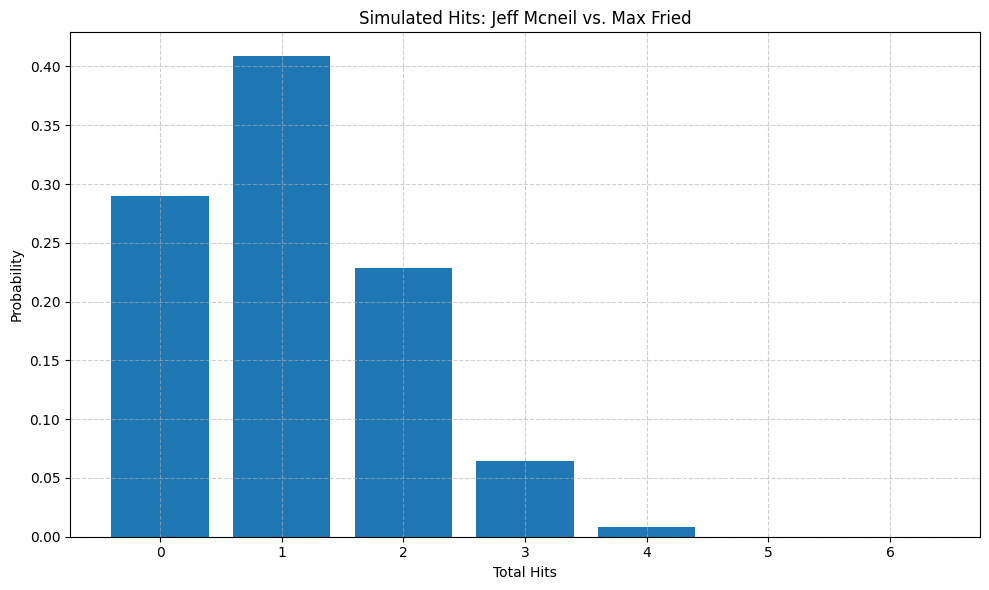

In [1]:
# mc_fried_vs_mcneil.py
import types, joblib, numpy as np, pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB
import AtBatSim
from baseball_utils import *

def load_pack(path: str):
    return types.SimpleNamespace(**joblib.load(path))

def build_models_from_pitcher_df(pitcher_pack):
    df = getattr(pitcher_pack, "pitcher_data_arch", None)
    if df is None or len(df) == 0:
        raise ValueError("pitcher_data_arch missing from pack. Export packs with include_full_df=True.")

    # --- Pitch (hybrid: lookup + NB) ---
    need_cols = ["stand_enc", "count_enc", "arch_enc", "pitch_cluster_enc"]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"pitcher_data_arch missing columns: {missing}")

    Xp = df[["stand_enc", "count_enc", "arch_enc"]].astype(int).values
    yp = df["pitch_cluster_enc"].astype(int).values

    pitch_lookup = defaultdict(Counter)
    for x, y in zip(Xp, yp):
        pitch_lookup[tuple(x)][int(y)] += 1
    nb_pitch = CategoricalNB().fit(Xp, yp)

    # --- Zone (hybrid: lookup + NB) ---
    dfz = df[df["zone"].notna() & df["zone"].isin(range(1, 15))].copy()
    dfz["zone_enc"] = dfz["zone"].astype(int) - 1  # count_enc already present
    Xz = dfz[["pitch_cluster_enc", "count_enc", "stand_enc"]].astype(int).values
    yz = dfz["zone_enc"].astype(int).values

    zone_lookup = defaultdict(Counter)
    for x, y in zip(Xz, yz):
        zone_lookup[tuple(x)][int(y)] += 1
    nb_zone = CategoricalNB().fit(Xz, yz)

    return nb_pitch, pitch_lookup, nb_pitch.classes_, nb_zone, zone_lookup, nb_zone.classes_

# ---- bullpen/extras helpers (no GI) ----
def simulate_reliever_innings(simulated_ip, is_hitter_home, hitter_win_pct, pitcher_win_pct):
    if not is_hitter_home:
        relief_ip = 9 - simulated_ip
    else:
        prob_not_hitting_9th = hitter_win_pct / (hitter_win_pct + pitcher_win_pct + 1e-9)
        hits_in_9th = np.random.random() > prob_not_hitting_9th
        relief_ip = 9 - simulated_ip if hits_in_9th else 8 - simulated_ip
    relief_ip = max(0.0, relief_ip)
    n = int(relief_ip); frac = relief_ip - n
    if 0.3 <= frac < 0.5: return n + 0.1
    if 0.5 <= frac < 0.7: return n + 0.2
    return float(n)

def outs_from_ip(ip: float) -> int:
    whole, frac = divmod(round(ip*10), 10)
    return whole*3 + (2 if frac==2 else 1 if frac==1 else 0)

def simulate_pen_bf(ip_needed: float, bf_per_out) -> int:
    outs_req = outs_from_ip(ip_needed)
    if outs_req <= 0: return 0
    arr = np.asarray(bf_per_out, dtype=float)
    if arr.size == 0: return 0
    samples = np.random.choice(arr, size=outs_req, replace=True)
    if samples[-1] == 0.5:  # avoid lone DP tail
        while True:
            new = np.random.choice(arr, size=1)[0]
            if new != 0.5:
                samples[-1] = new
                break
    return int(samples.sum())

def hitter_facing_relief(simulated_bf: int, lineup_spot: int, bp_bf_sim: int) -> int:
    next_spot = (simulated_bf % 9) + 1
    return sum(1 for i in range(bp_bf_sim) if ((next_spot + i - 1) % 9 + 1) == lineup_spot)

def simulate_hits_in_extras(prob_extra_innings, is_hitter_home, hitter_spot,
                            total_bf_pre_extras, hitter_xba,
                            bf_per_out_dist, home_IP_extras, away_IP_extras):
    if np.random.rand() >= prob_extra_innings:
        return {'extra_happens': False, 'mcneil_hits': 0}
    extras_pool = home_IP_extras if (not is_hitter_home) else away_IP_extras
    if not extras_pool:
        return {'extra_happens': True, 'mcneil_hits': 0}

    extra_ip = float(np.random.choice(extras_pool))
    ip_int = int(extra_ip); ip_frac = extra_ip - ip_int
    if np.isclose(ip_frac, 0.33): extra_ip = ip_int + 0.1
    elif np.isclose(ip_frac, 0.67): extra_ip = ip_int + 0.2

    outs_needed = outs_from_ip(extra_ip)
    if outs_needed <= 0:
        return {'extra_happens': True, 'mcneil_hits': 0}

    arr = np.asarray(bf_per_out_dist, dtype=float)
    if arr.size == 0:
        total_bf = 0
    else:
        bf_samples = np.random.choice(arr, size=outs_needed, replace=True)
        while bf_samples[-1] == 0.5:
            bf_samples[-1] = np.random.choice(arr)
        total_bf = int(round(bf_samples.sum()))

    next_spot = (total_bf_pre_extras % 9) + 1
    mc_ab = sum(1 for i in range(total_bf) if ((next_spot + i - 1) % 9 + 1) == hitter_spot)
    hits = np.random.binomial(mc_ab, float(hitter_xba))
    return {'extra_happens': True, 'mcneil_hits': int(hits)}

# ---------- helper to resolve hitter xBA (uses new hierarchical table if present) ----------
def _resolve_hitter_xba(hitter, fallback=0.300):
    tbl = getattr(hitter, "xba_lookup_table", None)
    # New hierarchical schema: use global mean if present
    if isinstance(tbl, dict) and "G" in tbl:
        g = tbl["G"].get(("__GLOBAL__",), None)
        if isinstance(g, dict) and g.get("n", 0) > 0:
            return float(g["sum"] / g["n"])
    # Stored by builder
    if getattr(hitter, "global_bip_xba", None) is not None:
        return float(hitter.global_bip_xba)
    # Legacy packs (single float)
    if getattr(hitter, "xba", None) is not None:
        return float(hitter.xba)
    return float(fallback)

# ---------- load packs ----------
mcneil = load_pack("packs/hitter_mcneil.joblib")
fried  = load_pack("packs/pitcher_fried.joblib")


# ---------- models from pitcher df (Fried) ----------
(nb_pitch_model, pitch_lookup_table, pitch_class_labels,
 nb_zone_model,  zone_lookup_table,  zone_class_labels) = build_models_from_pitcher_df(fried)

# ---------- team wOBA table ----------
team_woba = pd.DataFrame({
    "Team": ["CHC","NYY","TOR","LAD","ARI","BOS","DET","NYM","MIL","SEA",
             "PHI","HOU","STL","ATH","ATL","SDP","TBR","BAL","MIN","MIA",
             "TEX","CIN","SFG","CLE","LAA","WSN","KCR","PIT","CHW","COL"],
    "wOBA": [0.333,0.337,0.328,0.334,0.329,0.328,0.322,0.317,0.313,0.319,
             0.323,0.318,0.312,0.323,0.311,0.307,0.316,0.314,0.312,0.309,
             0.298,0.313,0.302,0.296,0.311,0.305,0.298,0.285,0.293,0.296]
})
team_to_abbr = {
    "Angels":"LAA","Astros":"HOU","Athletics":"OAK","Blue Jays":"TOR","Braves":"ATL","Brewers":"MIL",
    "Cardinals":"STL","Cubs":"CHC","Diamondbacks":"ARI","Dodgers":"LAD","Giants":"SFG","Guardians":"CLE",
    "Mariners":"SEA","Marlins":"MIA","Mets":"NYM","Nationals":"WSN","Orioles":"BAL","Padres":"SDP",
    "Phillies":"PHI","Pirates":"PIT","Rangers":"TEX","Rays":"TBR","Reds":"CIN","Red Sox":"BOS",
    "Rockies":"COL","Royals":"KCR","Tigers":"DET","Twins":"MIN","White Sox":"CWS","Yankees":"NYY"
}

# ---------- pull bullpen/extras assets once ----------
BF_PER_OUT = np.array(getattr(fried, "bf_per_out", []), dtype=float)
if BF_PER_OUT.size == 0: BF_PER_OUT = np.array([1.0], dtype=float)
HOME_EXTRAS = getattr(fried, "home_IP_extras", [])
AWAY_EXTRAS = getattr(fried, "away_IP_extras", [])
P_EXTRAS    = float(getattr(fried, "prob_extra_innings", 0.09) or 0.09)

# ---------- win pct dict ----------
win_pct_dict = {
    mcneil.team_name: float(getattr(mcneil, "winning_pct_value", 0.5) or 0.5),
    fried.team:       float(getattr(fried,  "winning_pct_value", 0.5) or 0.5),
}

# ---------- main Monte Carlo ----------
def simulate_total_hits(hitter, pitcher, num_trials,
                        nb_pitch_model, pitch_lookup_table, pitch_class_labels,
                        nb_zone_model,  zone_lookup_table,  zone_class_labels,
                        verbose=False):

    def round_to_thirds(ip): return round(ip * 3) / 3

    hit_results = []
    is_home = True  # parameterize later if needed

    hitter_abbr = team_to_abbr[hitter.team_name]
    team_woba_val = team_woba.loc[team_woba["Team"] == hitter_abbr, "wOBA"].values[0]

    IP_model = pitcher.IPLinReg
    BF_model = pitcher.poisson_model
    ip_sigma = float(pitcher.ip_std)

    # NEW: use global BIP xBA from hierarchical table (fallbacks included)
    xba = _resolve_hitter_xba(hitter, fallback=0.300)
    spot = int(getattr(hitter, "most_recent_spot", 3) or 3)

    for _ in range(num_trials):
        # starter IP
        expected_ip = float(IP_model.predict([[team_woba_val]])[0])
        simulated_ip = round_to_thirds(np.random.normal(expected_ip, ip_sigma))
        simulated_ip = float(np.clip(simulated_ip, 0.0, 9.0))

        # starter BF
        expected_bf = float(BF_model.predict(pd.DataFrame({"ip":[simulated_ip]}))[0])
        simulated_bf = int(np.random.poisson(expected_bf))

        # PA vs starter
        full_cycles = simulated_bf // 9
        remainder   = simulated_bf % 9
        pa_vs_sp    = full_cycles + (1 if spot <= remainder else 0)

        hits_vs_sp = 0
        for _ in range(pa_vs_sp):
            result, _log = AtBatSim.simulate_at_bat_between(
                hitter=hitter, pitcher=pitcher,
                nb_pitch_model=nb_pitch_model, pitch_lookup_table=pitch_lookup_table, pitch_class_labels=pitch_class_labels,
                nb_zone_model=nb_zone_model, zone_lookup_table=zone_lookup_table, zone_class_labels=zone_class_labels,
                verbose=False, verbose_audit=False
            )
            if result == "HIT":
                hits_vs_sp += 1

        # bullpen
        rel_ip = simulate_reliever_innings(
            simulated_ip, is_home,
            win_pct_dict[hitter.team_name],
            win_pct_dict[pitcher.team]
        )
        bp_bf   = simulate_pen_bf(rel_ip, BF_PER_OUT)
        pa_vs_rp = hitter_facing_relief(simulated_bf, spot, bp_bf)
        hits_vs_rp = np.random.binomial(n=pa_vs_rp, p=xba)

        # extras
        extras = simulate_hits_in_extras(
            prob_extra_innings=P_EXTRAS,
            is_hitter_home=is_home,
            hitter_spot=spot,
            total_bf_pre_extras=simulated_bf + bp_bf,
            hitter_xba=xba,
            bf_per_out_dist=BF_PER_OUT,
            home_IP_extras=HOME_EXTRAS,
            away_IP_extras=AWAY_EXTRAS
        )

        total_hits = hits_vs_sp + hits_vs_rp + extras["mcneil_hits"]
        hit_results.append(int(total_hits))

    return hit_results

# ---------- run ----------
results = simulate_total_hits(
    hitter=mcneil, pitcher=fried, num_trials=10000,
    nb_pitch_model=nb_pitch_model, pitch_lookup_table=pitch_lookup_table, pitch_class_labels=pitch_class_labels,
    nb_zone_model=nb_zone_model, zone_lookup_table=zone_lookup_table, zone_class_labels=zone_class_labels
)

# ---------- visualize ----------
hit_counts = Counter(results)
max_hits = max(hit_counts.keys()) if hit_counts else 0
empirical_pdf = [hit_counts.get(i, 0) / len(results) for i in range(max_hits + 1)] if results else [1.0]

plt.figure(figsize=(10, 6))
plt.bar(range(max_hits + 1), empirical_pdf)
plt.title(f"Simulated Hits: {mcneil.full_upper} vs. {fried.full_upper}")
plt.xlabel("Total Hits")
plt.ylabel("Probability")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()